# 導入不同策略 根據最新300根k棒產生的買賣序列 進行回測 畫出圖表

pool_df
              project     symbol                               pool_id  \
1  pancakeswap-amm-v3  CAKE-USDC  a338fec1-3874-40a5-97c4-79fa970dbfbb   

         apy  tvlUsd  
1  166.83307  159785  

📈 Price Timestamp Info:
起始時間: 2024-07-27 00:00:00
結束時間: 2025-07-26 00:00:00
筆數: 365
價格資料間隔（秒）: 86400.0

📊 APY Timestamp Info:
起始時間: 2023-04-13 22:13:41.138000+00:00
結束時間: 2025-07-26 17:06:05.191000+00:00
筆數: 810
APY 資料間隔（秒）: 86396.314
apy_df
                           timestamp        apy
0   2023-04-13 22:13:41.138000+00:00  106.78206
1   2023-04-14 23:03:24.976000+00:00  180.16263
2   2023-04-15 23:02:36.854000+00:00   74.79422
3   2023-04-16 22:03:51.793000+00:00  101.50664
4          2023-04-17 23:13:38+00:00  109.65519
..                               ...        ...
805 2025-07-22 23:06:32.168000+00:00  186.70516
806 2025-07-23 23:06:49.747000+00:00  223.29043
807 2025-07-24 23:06:05.832000+00:00  187.19980
808 2025-07-25 23:07:33.729000+00:00  173.50472
809 2025-07-26 17:06:05.19

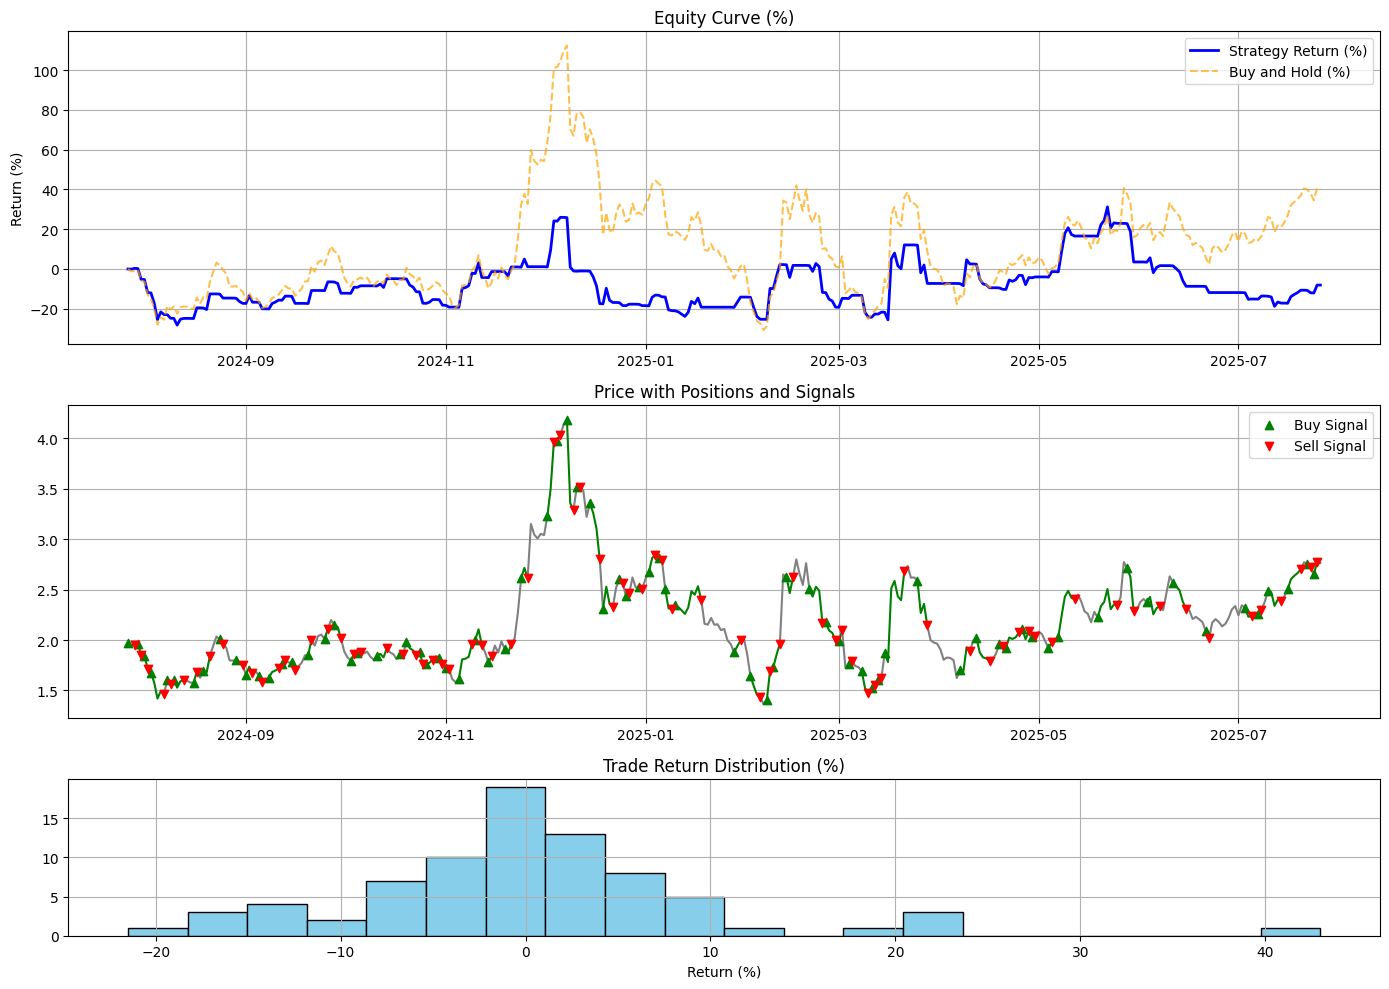

In [3]:
import Technicalindicatorstrategy
from datetime import datetime
from Backtest.backtest import backtest_signals
from Plot.plot import plot_backtest_result
import warnings 
warnings.filterwarnings('ignore')

strategies = "apy"
strat_module = getattr(Technicalindicatorstrategy, strategies)
df_signals = strat_module.get_signals("CAKEUSDT", "1d", datetime.now(),limit=365)
result = backtest_signals(df_signals, 
                        initial_capital=100, 
                        fee_rate=0.001, 
                        leverage=1, 
                        allow_short=False)
plot_backtest_result(result)
